In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from numpy.typing import NDArray
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

from authorship_id.utils import (
    pos_tag_text,
    preprocessing,
    setup_nltk,
    set_seed,
)

In [2]:
SEED = 42
setup_nltk()
set_seed(SEED)
dataset_dir = Path("../../pan_dataset")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [3]:
train_texts, train_labels = [], []
train_path = dataset_dir / "train"

const_len_to_trim = len("12Ctrain")
for file_path in sorted(train_path.glob("12Ctrain*.txt")):
    name = file_path.stem
    label = name[const_len_to_trim : const_len_to_trim + 1]
    with file_path.open(encoding="utf-8") as f:
        train_texts.append(f.read())
        train_labels.append(label)

In [4]:
test_texts = []
test_path = dataset_dir / "test"
for file_path in sorted(test_path.glob("12Ctest*.txt")):
    with file_path.open(encoding="utf-8") as f:
        test_texts.append(f.read())

In [5]:
unique_labels = sorted(set(train_labels))
label2id: dict[str, np.int64] = {
    lbl: np.int64(idx) for idx, lbl in enumerate(unique_labels)
}
id2label: dict[np.int64, str] = {idx: lbl for lbl, idx in label2id.items()}

y_train: NDArray[np.int64] = np.array([label2id[lbl] for lbl in train_labels])
y_test: NDArray[np.int64] = np.array([label2id[lbl] for lbl in ["C", "E", "A", "F", "H", "B", "G", "D"]])

train_texts = list(map(pos_tag_text, train_texts))
test_texts = list(map(pos_tag_text, test_texts))

In [6]:
ngram_ranges_to_test = [(1, 1), (2, 2), (3, 3)]
min_df_to_test = [1, 2]
results_df = pd.DataFrame(columns=["Model", "Accuracy", "n_gram", "min_df"])
models = {
    "RF": lambda: RandomForestClassifier(n_estimators=100, max_depth=50, random_state=SEED),
    "DT": lambda: DecisionTreeClassifier(criterion="entropy", max_depth=50, random_state=SEED),
    "SVM": lambda: LinearSVC(dual=True),
    "LogReg": lambda: LogisticRegression(max_iter=500, random_state=SEED),
    "KNN": lambda: KNeighborsClassifier(n_neighbors=5, metric="cosine"),
    "MLP": lambda: MLPClassifier(random_state=SEED, max_iter=300),
}

all_preds = {}

for model_name in models:
    best_accuracy = 0
    best_params = {}

    for ngram_range in ngram_ranges_to_test:
        for min_df in min_df_to_test:
            print(
                f"--- Testing {model_name} with ngram_range={ngram_range}, min_df={min_df} ---"
            )

            X_train, X_test, _ = preprocessing(
                train_texts,
                test_texts,
                ngram_range=ngram_range,
                min_doc_freq=min_df,
                vectorizer_name="tfidf",
            )

            display(("X_train", "y_train", "X_test", "y_test"))
            display((X_train.shape, y_train.shape, X_test.shape, y_test.shape))

            model = models[model_name]()
            model.fit(X_train, y_train)

            preds = model.predict(X_test)
            accuracy = accuracy_score(y_test, preds)
            print(f"Accuracy: {accuracy:.4f}")

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {"ngram_range": ngram_range, "min_df": min_df}
                all_preds[model_name] = preds

    new_row = pd.Series(
        {
            "Model": model_name,
            "Accuracy": best_accuracy * 100,
            "n_gram": best_params["ngram_range"],
            "min_df": best_params["min_df"],
        }
    )
    results_df = pd.concat([results_df, new_row.to_frame().T], ignore_index=True)

--- Testing RF with ngram_range=(1, 1), min_df=1 ---


('X_train', 'y_train', 'X_test', 'y_test')

((16, 43), (16,), (8, 43), (8,))

Accuracy: 1.0000
--- Testing RF with ngram_range=(1, 1), min_df=2 ---


('X_train', 'y_train', 'X_test', 'y_test')

((16, 42), (16,), (8, 42), (8,))

Accuracy: 1.0000
--- Testing RF with ngram_range=(2, 2), min_df=1 ---


('X_train', 'y_train', 'X_test', 'y_test')

((16, 1027), (16,), (8, 1027), (8,))

Accuracy: 0.7500
--- Testing RF with ngram_range=(2, 2), min_df=2 ---


('X_train', 'y_train', 'X_test', 'y_test')

((16, 836), (16,), (8, 836), (8,))

Accuracy: 1.0000
--- Testing RF with ngram_range=(3, 3), min_df=1 ---


('X_train', 'y_train', 'X_test', 'y_test')

((16, 8387), (16,), (8, 8387), (8,))

Accuracy: 0.7500
--- Testing RF with ngram_range=(3, 3), min_df=2 ---


('X_train', 'y_train', 'X_test', 'y_test')

((16, 5038), (16,), (8, 5038), (8,))

Accuracy: 0.6250
--- Testing DT with ngram_range=(1, 1), min_df=1 ---


('X_train', 'y_train', 'X_test', 'y_test')

((16, 43), (16,), (8, 43), (8,))

Accuracy: 0.5000
--- Testing DT with ngram_range=(1, 1), min_df=2 ---


('X_train', 'y_train', 'X_test', 'y_test')

((16, 42), (16,), (8, 42), (8,))

Accuracy: 0.2500
--- Testing DT with ngram_range=(2, 2), min_df=1 ---


('X_train', 'y_train', 'X_test', 'y_test')

((16, 1027), (16,), (8, 1027), (8,))

Accuracy: 0.1250
--- Testing DT with ngram_range=(2, 2), min_df=2 ---


('X_train', 'y_train', 'X_test', 'y_test')

((16, 836), (16,), (8, 836), (8,))

Accuracy: 0.3750
--- Testing DT with ngram_range=(3, 3), min_df=1 ---


('X_train', 'y_train', 'X_test', 'y_test')

((16, 8387), (16,), (8, 8387), (8,))

Accuracy: 0.3750
--- Testing DT with ngram_range=(3, 3), min_df=2 ---


('X_train', 'y_train', 'X_test', 'y_test')

((16, 5038), (16,), (8, 5038), (8,))

Accuracy: 0.3750
--- Testing SVM with ngram_range=(1, 1), min_df=1 ---


('X_train', 'y_train', 'X_test', 'y_test')

((16, 43), (16,), (8, 43), (8,))

Accuracy: 0.8750
--- Testing SVM with ngram_range=(1, 1), min_df=2 ---


D:\mle_proj\authorship_id\.venv\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


('X_train', 'y_train', 'X_test', 'y_test')

((16, 42), (16,), (8, 42), (8,))

Accuracy: 0.8750
--- Testing SVM with ngram_range=(2, 2), min_df=1 ---


D:\mle_proj\authorship_id\.venv\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


('X_train', 'y_train', 'X_test', 'y_test')

((16, 1027), (16,), (8, 1027), (8,))

Accuracy: 0.8750
--- Testing SVM with ngram_range=(2, 2), min_df=2 ---


('X_train', 'y_train', 'X_test', 'y_test')

((16, 836), (16,), (8, 836), (8,))

Accuracy: 1.0000
--- Testing SVM with ngram_range=(3, 3), min_df=1 ---


('X_train', 'y_train', 'X_test', 'y_test')

((16, 8387), (16,), (8, 8387), (8,))

Accuracy: 0.8750
--- Testing SVM with ngram_range=(3, 3), min_df=2 ---


('X_train', 'y_train', 'X_test', 'y_test')

((16, 5038), (16,), (8, 5038), (8,))

Accuracy: 0.8750
--- Testing LogReg with ngram_range=(1, 1), min_df=1 ---


('X_train', 'y_train', 'X_test', 'y_test')

((16, 43), (16,), (8, 43), (8,))

Accuracy: 1.0000
--- Testing LogReg with ngram_range=(1, 1), min_df=2 ---


('X_train', 'y_train', 'X_test', 'y_test')

((16, 42), (16,), (8, 42), (8,))

Accuracy: 1.0000
--- Testing LogReg with ngram_range=(2, 2), min_df=1 ---


('X_train', 'y_train', 'X_test', 'y_test')

((16, 1027), (16,), (8, 1027), (8,))

Accuracy: 0.8750
--- Testing LogReg with ngram_range=(2, 2), min_df=2 ---


('X_train', 'y_train', 'X_test', 'y_test')

((16, 836), (16,), (8, 836), (8,))

Accuracy: 1.0000
--- Testing LogReg with ngram_range=(3, 3), min_df=1 ---


('X_train', 'y_train', 'X_test', 'y_test')

((16, 8387), (16,), (8, 8387), (8,))

Accuracy: 0.8750
--- Testing LogReg with ngram_range=(3, 3), min_df=2 ---


('X_train', 'y_train', 'X_test', 'y_test')

((16, 5038), (16,), (8, 5038), (8,))

Accuracy: 0.8750
--- Testing KNN with ngram_range=(1, 1), min_df=1 ---


('X_train', 'y_train', 'X_test', 'y_test')

((16, 43), (16,), (8, 43), (8,))

Accuracy: 0.7500
--- Testing KNN with ngram_range=(1, 1), min_df=2 ---


('X_train', 'y_train', 'X_test', 'y_test')

((16, 42), (16,), (8, 42), (8,))

Accuracy: 0.7500
--- Testing KNN with ngram_range=(2, 2), min_df=1 ---


('X_train', 'y_train', 'X_test', 'y_test')

((16, 1027), (16,), (8, 1027), (8,))

Accuracy: 0.7500
--- Testing KNN with ngram_range=(2, 2), min_df=2 ---


('X_train', 'y_train', 'X_test', 'y_test')

((16, 836), (16,), (8, 836), (8,))

Accuracy: 0.5000
--- Testing KNN with ngram_range=(3, 3), min_df=1 ---


('X_train', 'y_train', 'X_test', 'y_test')

((16, 8387), (16,), (8, 8387), (8,))

Accuracy: 0.6250
--- Testing KNN with ngram_range=(3, 3), min_df=2 ---


('X_train', 'y_train', 'X_test', 'y_test')

((16, 5038), (16,), (8, 5038), (8,))

Accuracy: 0.3750
--- Testing MLP with ngram_range=(1, 1), min_df=1 ---


('X_train', 'y_train', 'X_test', 'y_test')

((16, 43), (16,), (8, 43), (8,))

Accuracy: 0.7500
--- Testing MLP with ngram_range=(1, 1), min_df=2 ---


D:\mle_proj\authorship_id\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


('X_train', 'y_train', 'X_test', 'y_test')

((16, 42), (16,), (8, 42), (8,))

Accuracy: 0.7500
--- Testing MLP with ngram_range=(2, 2), min_df=1 ---


D:\mle_proj\authorship_id\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


('X_train', 'y_train', 'X_test', 'y_test')

((16, 1027), (16,), (8, 1027), (8,))

Accuracy: 0.3750
--- Testing MLP with ngram_range=(2, 2), min_df=2 ---


('X_train', 'y_train', 'X_test', 'y_test')

((16, 836), (16,), (8, 836), (8,))

Accuracy: 0.7500
--- Testing MLP with ngram_range=(3, 3), min_df=1 ---


('X_train', 'y_train', 'X_test', 'y_test')

((16, 8387), (16,), (8, 8387), (8,))

Accuracy: 0.3750
--- Testing MLP with ngram_range=(3, 3), min_df=2 ---


('X_train', 'y_train', 'X_test', 'y_test')

((16, 5038), (16,), (8, 5038), (8,))

Accuracy: 0.5000


In [7]:
best_accuracy = 0
best_params = {}
model_name = "RF_Count"

for ngram_range in ngram_ranges_to_test:
    for min_df in min_df_to_test:
        print(
            f"--- Testing {model_name} with ngram_range={ngram_range}, min_df={min_df} ---"
        )

        X_train, X_test, _ = preprocessing(
            train_texts,
            test_texts,
            ngram_range=ngram_range,
            min_doc_freq=min_df,
            vectorizer_name="count",
        )

        display(("X_train", "y_train", "X_test", "y_test"))
        display((X_train.shape, y_train.shape, X_test.shape, y_test.shape))

        model = models["RF"]()
        model.fit(X_train, y_train)

        preds = model.predict(X_test)
        accuracy = accuracy_score(y_test, preds)
        print(f"Accuracy: {accuracy:.4f}")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = {"ngram_range": ngram_range, "min_df": min_df}
            all_preds[model_name] = preds

new_row = pd.Series(
    {
        "Model": model_name,
        "Accuracy": best_accuracy * 100,
        "n_gram": best_params["ngram_range"],
        "min_df": best_params["min_df"],
    }
)
results_df = pd.concat([results_df, new_row.to_frame().T], ignore_index=True)

display(results_df)

--- Testing RF_Count with ngram_range=(1, 1), min_df=1 ---


('X_train', 'y_train', 'X_test', 'y_test')

((16, 43), (16,), (8, 43), (8,))

Accuracy: 0.8750
--- Testing RF_Count with ngram_range=(1, 1), min_df=2 ---


('X_train', 'y_train', 'X_test', 'y_test')

((16, 42), (16,), (8, 42), (8,))

Accuracy: 0.7500
--- Testing RF_Count with ngram_range=(2, 2), min_df=1 ---


('X_train', 'y_train', 'X_test', 'y_test')

((16, 1027), (16,), (8, 1027), (8,))

Accuracy: 0.5000
--- Testing RF_Count with ngram_range=(2, 2), min_df=2 ---


('X_train', 'y_train', 'X_test', 'y_test')

((16, 836), (16,), (8, 836), (8,))

Accuracy: 0.6250
--- Testing RF_Count with ngram_range=(3, 3), min_df=1 ---


('X_train', 'y_train', 'X_test', 'y_test')

((16, 8387), (16,), (8, 8387), (8,))

Accuracy: 0.5000
--- Testing RF_Count with ngram_range=(3, 3), min_df=2 ---


('X_train', 'y_train', 'X_test', 'y_test')

((16, 5038), (16,), (8, 5038), (8,))

Accuracy: 0.5000


,Model,Accuracy,n_gram,min_df
0,RF,100.0,"(1, 1)",1
1,DT,50.0,"(1, 1)",1
2,SVM,100.0,"(2, 2)",2
3,LogReg,100.0,"(1, 1)",1
4,KNN,75.0,"(1, 1)",1
5,MLP,75.0,"(1, 1)",1
6,RF_Count,87.5,"(1, 1)",1


In [8]:
display(all_preds)
display(y_test)

{'RF': array([2, 4, 0, 5, 7, 1, 6, 3]),
 'DT': array([2, 0, 0, 2, 3, 1, 0, 3]),
 'SVM': array([2, 4, 0, 5, 7, 1, 6, 3]),
 'LogReg': array([2, 4, 0, 5, 7, 1, 6, 3]),
 'KNN': array([2, 4, 0, 5, 7, 1, 1, 5]),
 'MLP': array([2, 0, 0, 5, 0, 1, 6, 3]),
 'RF_Count': array([1, 4, 0, 5, 7, 1, 6, 3])}

array([2, 4, 0, 5, 7, 1, 6, 3])

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8



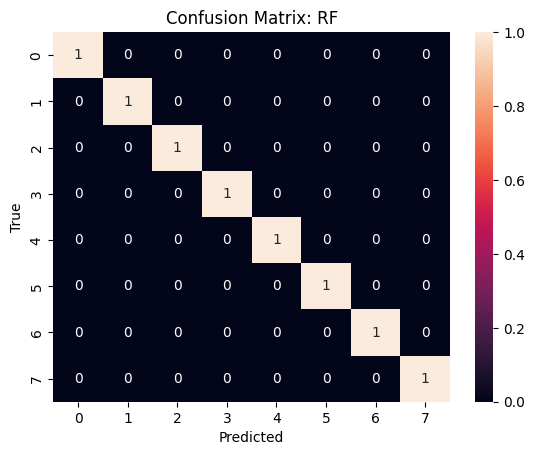

              precision    recall  f1-score   support

           0       0.33      1.00      0.50         1
           1       1.00      1.00      1.00         1
           2       0.50      1.00      0.67         1
           3       0.50      1.00      0.67         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1

    accuracy                           0.50         8
   macro avg       0.29      0.50      0.35         8
weighted avg       0.29      0.50      0.35         8



D:\mle_proj\authorship_id\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\mle_proj\authorship_id\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\mle_proj\authorship_id\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


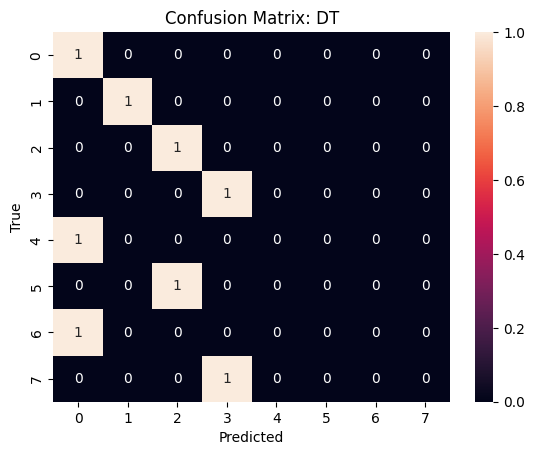

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8



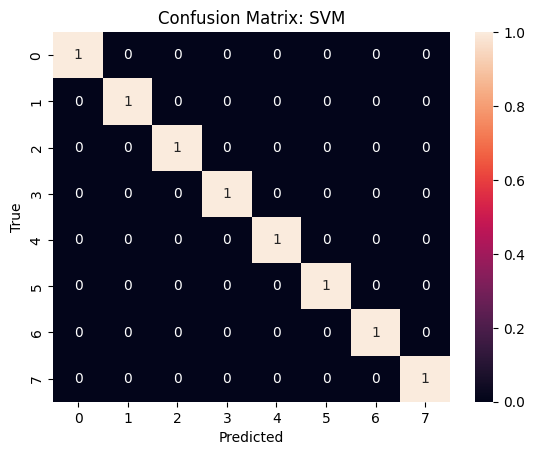

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8



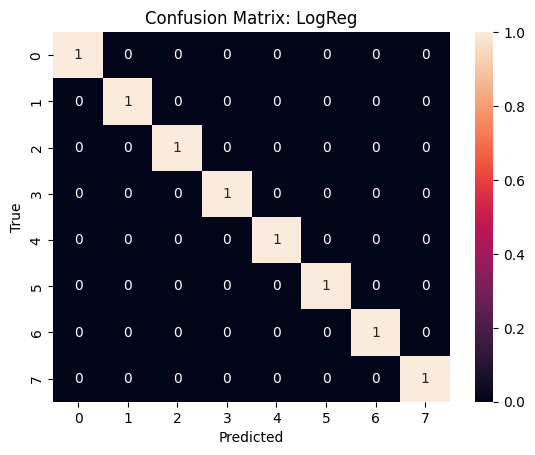

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.50      1.00      0.67         1
           2       1.00      1.00      1.00         1
           3       0.00      0.00      0.00         1
           4       1.00      1.00      1.00         1
           5       0.50      1.00      0.67         1
           6       0.00      0.00      0.00         1
           7       1.00      1.00      1.00         1

    accuracy                           0.75         8
   macro avg       0.62      0.75      0.67         8
weighted avg       0.62      0.75      0.67         8



D:\mle_proj\authorship_id\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\mle_proj\authorship_id\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\mle_proj\authorship_id\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


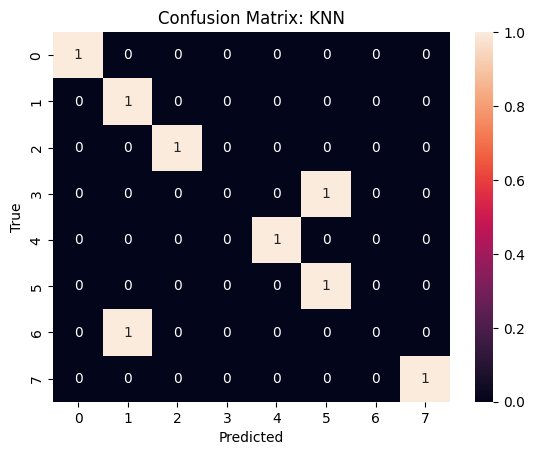

D:\mle_proj\authorship_id\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\mle_proj\authorship_id\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\mle_proj\authorship_id\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


              precision    recall  f1-score   support

           0       0.33      1.00      0.50         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       0.00      0.00      0.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       0.00      0.00      0.00         1

    accuracy                           0.75         8
   macro avg       0.67      0.75      0.69         8
weighted avg       0.67      0.75      0.69         8



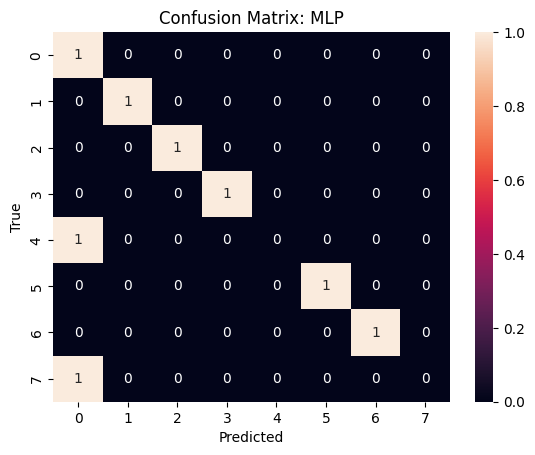

In [9]:
for model_name in models:
    print(classification_report(y_test, all_preds[model_name]))
    cm = confusion_matrix(y_test, all_preds[model_name])
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

In [10]:
display(results_df[results_df["Model"].isin(("RF", "RF_Count"))])

,Model,Accuracy,n_gram,min_df
0,RF,100.0,"(1, 1)",1
6,RF_Count,87.5,"(1, 1)",1
